#### Import needed modules

In [ ]:
import os
import random

import pickle as pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


#### Load all available ecg data

In [4]:
# Load data
data_path = r'E:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\ecg_data.csv'
data = pd.read_csv(data_path, index_col=0)

# Splitting features and labels
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [ ]:
from sklearn.metrics import make_scorer, auc, precision_recall_curve

def pr_auc_score(y_true, y_pred_proba):
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        return auc(recall, precision)

outer = range(0,4000)

best_params_dict = {}
best_model_dict = {}

# Initialize variables to store precision-recall data
precision_list = []
recall_list = []
auc_list = []

for outer_rand in tqdm(outer, desc='Outer Loop'):
    # Split data into outer folds
    X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(
            x, y, test_size=0.2, stratify=y, shuffle=True, random_state=outer_rand)
    
    # Scale features using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_outer = scaler.fit_transform(X_train_outer)
    X_test_outer = scaler.transform(X_test_outer)
    
    # Apply PCA
    pca = PCA(n_components=0.95)  # Keep 95% variance
    X_train_outer = pca.fit_transform(X_train_outer)
    X_test_outer = pca.transform(X_test_outer)

    # Create a pipeline with scaling, PCA, and KNeighborsClassifier
    param_grid_knn = {
        'knn__n_neighbors': list(range(3, 25)),  # Iterate over k from 3 to 24
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan'],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }

    pipeline = Pipeline([
        ('knn', KNeighborsClassifier())
    ])

    # For classification problems to maintain class distribution
    cv_inner = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
        
    pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=True)

    random_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid_knn,
        scoring=pr_auc_scorer,
        cv=cv_inner,
        n_jobs=-1
    )

    random_search.fit(X_train_outer, y_train_outer)

    best_params = random_search.best_params_
    best_params_dict[f"Outer {outer_rand}"] = best_params
    best_model_dict[f"Outer {outer_rand}"] = random_search.best_estimator_

    
    y_pred = best_model_dict[f"Outer {outer_rand}"].predict(X_test_outer)
    tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()

    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    y_pred_proba = best_model_dict[f"Outer {outer_rand}"].predict_proba(X_test_outer)[:, 1]
    auc_score = roc_auc_score(y_test_outer, y_pred_proba)
    f1 = f1_score(y_test_outer, y_pred)
    accuracy = accuracy_score(y_test_outer, y_pred)
    
    # precision recall curve
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_proba)
    precision_list.append(precision)
    recall_list.append(recall)
    auc_list.append(auc(recall, precision))

    best_params_dict[f"Outer {outer_rand}"]['auc'] = auc_score
    best_params_dict[f"Outer {outer_rand}"]['f1'] = f1
    best_params_dict[f"Outer {outer_rand}"]['sensitivity'] = sensitivity
    best_params_dict[f"Outer {outer_rand}"]['specificity'] = specificity
    best_params_dict[f"Outer {outer_rand}"]['accuracy'] = accuracy
    

    print(f"\nOuter {outer_rand} -> Best Hyperparameters: {best_params}")

    # Save results
    results_df = pd.DataFrame.from_dict(best_params_dict, orient='index')
    results_csv_path = os.path.join(os.getcwd(), 'best_hyperparameters_short.csv')
    results_df.to_csv(results_csv_path)
    print(f"\nBest parameters saved to {results_csv_path} after Outer {outer_rand} completion")

    # Save precision-recall data
    pr_data = {
        "precision_list": precision_list,
        "recall_list": recall_list,
        "auc_list": auc_list
    }
    pr_data_path = os.path.join(os.getcwd(), 'precision_recall_data.pkl')
    with open(pr_data_path, 'wb') as f:
        pickle.dump(pr_data, f)
    print(f"\nPrecision-recall data saved to {pr_data_path} after Outer {outer_rand} completion")



Outer Loop:   3%|▎         | 1/30 [00:09<04:29,  9.28s/it]


Outer 0 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 19, 'knn__weights': 'distance', 'auc': 0.6440976591995974, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 0 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 0 completion


Outer Loop:   7%|▋         | 2/30 [00:15<03:24,  7.29s/it]


Outer 1 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 22, 'knn__weights': 'uniform', 'auc': 0.7698212937326957, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 1 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 1 completion


Outer Loop:  10%|█         | 3/30 [00:20<02:58,  6.61s/it]


Outer 2 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__weights': 'distance', 'auc': 0.6194311603322427, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 2 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 2 completion


Outer Loop:  13%|█▎        | 4/30 [00:29<03:09,  7.28s/it]


Outer 3 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 13, 'knn__weights': 'distance', 'auc': 0.5872136924238611, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 3 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 3 completion


Outer Loop:  17%|█▋        | 5/30 [00:34<02:46,  6.65s/it]


Outer 4 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'uniform', 'auc': 0.5747545935061666, 'f1': 0.1212121212121212, 'sensitivity': 0.06896551724137931, 'specificity': 0.9854014598540146, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 4 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 4 completion


Outer Loop:  20%|██        | 6/30 [00:40<02:28,  6.17s/it]


Outer 5 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 19, 'knn__weights': 'uniform', 'auc': 0.7175937578655928, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 5 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 5 completion


Outer Loop:  23%|██▎       | 7/30 [00:47<02:29,  6.51s/it]


Outer 6 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'auc': 0.5441731688900074, 'f1': 0.1111111111111111, 'sensitivity': 0.06896551724137931, 'specificity': 0.9635036496350365, 'accuracy': 0.8072289156626506}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 6 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 6 completion


Outer Loop:  27%|██▋       | 8/30 [00:54<02:28,  6.76s/it]


Outer 7 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 24, 'knn__weights': 'uniform', 'auc': 0.6687641580669519, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 7 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 7 completion


Outer Loop:  30%|███       | 9/30 [01:00<02:13,  6.36s/it]


Outer 8 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 24, 'knn__weights': 'uniform', 'auc': 0.724389630002517, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 8 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 8 completion


Outer Loop:  33%|███▎      | 10/30 [01:05<02:00,  6.02s/it]


Outer 9 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 22, 'knn__weights': 'distance', 'auc': 0.7389881701485024, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 9 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 9 completion


Outer Loop:  37%|███▋      | 11/30 [01:11<01:55,  6.07s/it]


Outer 10 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 24, 'knn__weights': 'uniform', 'auc': 0.6214447520765165, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 10 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 10 completion


Outer Loop:  40%|████      | 12/30 [01:17<01:48,  6.05s/it]


Outer 11 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 19, 'knn__weights': 'distance', 'auc': 0.6891517744777247, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 11 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 11 completion


Outer Loop:  43%|████▎     | 13/30 [01:22<01:39,  5.84s/it]


Outer 12 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 6, 'knn__weights': 'uniform', 'auc': 0.6605839416058394, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 12 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 12 completion


Outer Loop:  47%|████▋     | 14/30 [01:27<01:29,  5.62s/it]


Outer 13 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 20, 'knn__weights': 'uniform', 'auc': 0.5782783790586458, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 13 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 13 completion


Outer Loop:  50%|█████     | 15/30 [01:33<01:22,  5.51s/it]


Outer 14 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 6, 'knn__weights': 'distance', 'auc': 0.6308834633778002, 'f1': 0.1212121212121212, 'sensitivity': 0.06896551724137931, 'specificity': 0.9854014598540146, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 14 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 14 completion


Outer Loop:  53%|█████▎    | 16/30 [01:38<01:14,  5.34s/it]


Outer 15 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 22, 'knn__weights': 'uniform', 'auc': 0.6641077271583187, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 15 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 15 completion


Outer Loop:  57%|█████▋    | 17/30 [01:43<01:08,  5.25s/it]


Outer 16 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 20, 'knn__weights': 'uniform', 'auc': 0.67757362194815, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 16 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 16 completion


Outer Loop:  60%|██████    | 18/30 [01:48<01:03,  5.32s/it]


Outer 17 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 20, 'knn__weights': 'distance', 'auc': 0.7600050339793606, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 17 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 17 completion


Outer Loop:  63%|██████▎   | 19/30 [01:54<00:59,  5.44s/it]


Outer 18 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 18, 'knn__weights': 'distance', 'auc': 0.5145985401459854, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 18 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 18 completion


Outer Loop:  67%|██████▋   | 20/30 [02:00<00:56,  5.67s/it]


Outer 19 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 22, 'knn__weights': 'distance', 'auc': 0.7571104958469671, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 19 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 19 completion


Outer Loop:  70%|███████   | 21/30 [02:06<00:51,  5.77s/it]


Outer 20 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 12, 'knn__weights': 'distance', 'auc': 0.6569343065693432, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 20 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 20 completion


Outer Loop:  73%|███████▎  | 22/30 [02:12<00:46,  5.77s/it]


Outer 21 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__weights': 'distance', 'auc': 0.673168890007551, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 21 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 21 completion


Outer Loop:  77%|███████▋  | 23/30 [02:18<00:40,  5.75s/it]


Outer 22 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'auc': 0.7807701988421848, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 22 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 22 completion


Outer Loop:  80%|████████  | 24/30 [02:24<00:35,  5.90s/it]


Outer 23 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 20, 'knn__weights': 'uniform', 'auc': 0.6532846715328468, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 23 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 23 completion


Outer Loop:  83%|████████▎ | 25/30 [02:30<00:29,  5.87s/it]


Outer 24 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__weights': 'uniform', 'auc': 0.7267807701988421, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 24 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 24 completion


Outer Loop:  87%|████████▋ | 26/30 [02:35<00:23,  5.83s/it]


Outer 25 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 12, 'knn__weights': 'uniform', 'auc': 0.5909891769443746, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 25 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 25 completion


Outer Loop:  90%|█████████ | 27/30 [02:43<00:19,  6.39s/it]


Outer 26 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'distance', 'auc': 0.6735464384596024, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 26 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 26 completion


Outer Loop:  93%|█████████▎| 28/30 [02:49<00:12,  6.11s/it]


Outer 27 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 10, 'knn__weights': 'distance', 'auc': 0.6083564057387365, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 27 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 27 completion


Outer Loop:  97%|█████████▋| 29/30 [02:57<00:06,  6.83s/it]


Outer 28 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 24, 'knn__weights': 'uniform', 'auc': 0.6862572363453311, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 28 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 28 completion


Outer Loop: 100%|██████████| 30/30 [03:03<00:00,  6.10s/it]


Outer 29 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 16, 'knn__weights': 'distance', 'auc': 0.647118046816008, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 29 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 29 completion


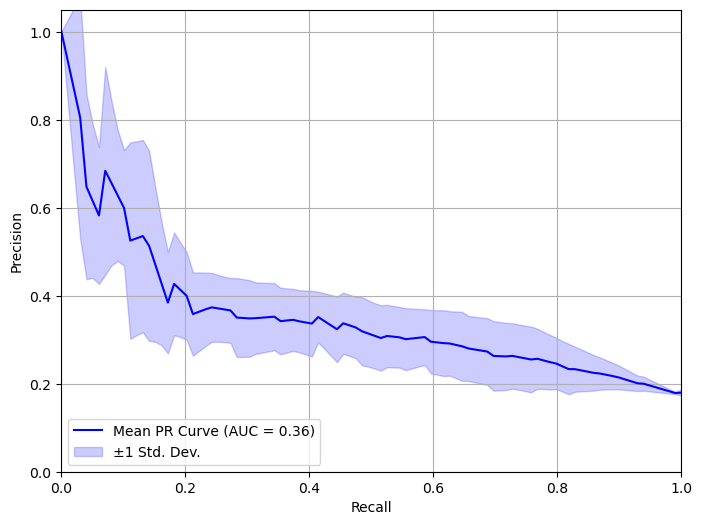

In [14]:
# Load precision-recall data from pickle file
pr_data_path = os.path.join(os.getcwd(), 'precision_recall_data.pkl')
with open(pr_data_path, 'rb') as f:
    pr_data = pickle.load(f)

# Extract precision, recall, and AUC lists
precision_list = pr_data["precision_list"]
recall_list = pr_data["recall_list"]
auc_list = pr_data["auc_list"]

# Calculate mean and standard deviation for precision-recall curves
mean_recall = np.linspace(0, 1, 100)
interp_precisions = []

for precision, recall in zip(precision_list, recall_list):
    # Sort recall and precision in increasing recall order
    order = np.argsort(recall)
    recall_sorted = recall[order]
    precision_sorted = precision[order]
    
    # Interpolate precision as a function of recall
    interp_precision = np.interp(mean_recall, recall_sorted, precision_sorted, left=1.0, right=0.0)
    interp_precisions.append(interp_precision)

# Calculate mean and std of precision at each recall level
mean_precision = np.mean(interp_precisions, axis=0)
std_precision = np.std(interp_precisions, axis=0)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, label=f"Mean PR Curve (AUC = {np.mean(auc_list):.2f})", color='b')
plt.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, color='b', alpha=0.2, label="±1 Std. Dev.")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")
plt.grid()
plt.show()